# Cohort 4 Screening
Bartosz Kusek

## Task 1

I'm going to work on the first task in this cohort because it seemed the most interesting (and the most algorithmic) to me. I implement the solution using qiskit.

### Contents

I start with preliminaries where I introduce some helpers. Then I go through all steps which sums up to the solution, i.e. construction of QRAM, Oracle, diffuser, the initialization and finally Grover's Algorithm.

After providing solution I draw some conclusions and attach some experiments at the end of the notebook.

### Preliminaries
I place here some helpers that I find useful. This also let us avoid explaining things during further work that might distract the reader from the solution itself (e.g. Gray coding).

#### Imports

In [1]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector

import numpy as np

#### Helpers
I start with general helpers and then go to the qc-related ones. When possible, I show an example of usage.

In [2]:
# casts int to binary string and pad it with zeros (up to n characters)
def int_to_bin(val, n):
    return "{0:0{1}b}".format(val, n)

int_to_bin(5, 4)

'0101'

In [3]:
# parses int from binary string
def bin_to_int(val):
    return int(val, 2)

bin_to_int('1101')

13

We'll use Gray code. The n-bit Gray code consists of all n-character bitstrings in such an order, that between every pair there is exactly one bit of difference. (see the example)

In [4]:
# generates list of n-char bitstring from Gray code
def gray(n):
    return ["{0:0{1}b}".format(i^(i>>1),n) for i in range(0, 1<<n)]

gray(3)

['000', '001', '011', '010', '110', '111', '101', '100']

In [5]:
# integers corresponding to the subsequent strings
list(map(bin_to_int, gray(3)))

[0, 1, 3, 2, 6, 7, 5, 4]

In [6]:
# finds an index of the difference bit in 2 bitstrings
def diff_idx(va, vb):
    for i, (a,b) in enumerate(zip(va, vb)):
        if a != b:
            return i
    return -1

diff_idx('0011', '0001')

2

#### qiskit helpers

In [7]:
# backends we will use
aer_simulator = Aer.get_backend('aer_simulator')
statevector_simulator = Aer.get_backend('statevector_simulator')

We will use Statevector Simulator to test some simple circuits. We will want to know all possible states of these circuits.

In [8]:
# gets the outputstate for given circuit from statevector simulator
def run_on_statevector(circ):
    job = statevector_simulator.run(circ)
    result = job.result()
    outputstate = result.get_statevector(circ)
    return outputstate

# map outputs state to dictionary with string keys
def get_statevector_dict(outputstate):
    return Statevector(outputstate).to_dict()

Second backend we will use is Aer, we will use it to run experiments with the main solution.

In [9]:
# gets the result for given circuit from aer simulator
def run_on_aer(circ):
    transpiled_qc = transpile(circ, aer_simulator)
    qobj = assemble(transpiled_qc)
    result = aer_simulator.run(qobj).result()
    return result

# plots probabilities of all states
def plot_aer_counts(aer_result):
    return plot_histogram(aer_result.get_counts())

### QRAM
We start with construction of simple QRAM. QRAM is a circuit consisting of 2 registers, one used to set the address in the memory and the second one to store the value. I call them address and value respectively. I've decided to built it in the simplest form, which means that in order to set a value we have to set a proper address on the address register and with use of multi-controlled-not's set proper bits of the value.

I define a `QRam` class which will be used as the struct gathering some values and the circuit we will work on. **N** and **M** are main parameters of given problem - we want to store **2^N** values consisting of **M** bits. QRam has also param **K** which is the number of additional qbits. We will get back to this regsiter later, when we prepare the oracle. Finally, we prepare classical bits to measure only the address register.

In order to reduce the number of `X` gates used to prepare address before I've decided to visit the addresses in the order induced by Gray coding, so beetween every 2 assignments only one gate will be applied.

In [10]:
class QRam:
    def __init__(self, N, M, K):
        self.N = N
        self.M = M
        self.K = K

        self.addr_reg = QuantumRegister(self.N, 'addr')
        self.val_reg = QuantumRegister(self.M, 'val')
        self.oracle_reg = QuantumRegister(self.K, 'oracle')
        self.measurements = ClassicalRegister(self.N, 'res')

        self.circ = QuantumCircuit(self.addr_reg, self.val_reg, self.oracle_reg, self.measurements)

        self.addresses = gray(self.N)
        
    
    def draw(self):
        return self.circ.draw(output='mpl')

We will operate on qram with methods modifying qram's circuit in place.

In [11]:
# applies measure gates on address register   
def measure(qram):
    for i in range(qram.N):
        qram.circ.measure(qram.addr_reg[i], i)

We will traverse all addresses in qram and set their values.
The procedure of building the qram circuit on registers stored in `QRam` instance is as follows:
1. Prepare addr register to reflect the current **addres**
1. With `MCX` gates set bits corresponding to the ones in **value**
1. Repeat until there are any (addr, value) pairs left

In [12]:
# prepares the next address on the addr register by applying x gate
def next_addr_on_qram(qram, addr_idx):
    new_addr_idx = addr_idx + 1
    diff_position = diff_idx(
        reversed(qram.addresses[addr_idx]),
        reversed(qram.addresses[new_addr_idx])
    )

    qram.circ.x(qram.addr_reg[diff_position])

# sets value on the val register for the address set
def set_value(qram, value):
    for i, v in enumerate(reversed(value)):
        if v == '1':
            qram.circ.mcx(qram.addr_reg[:], qram.val_reg[i])


# builds the qram circuit
def build_qram(qram, values):
    addr_idx = 0

    # set the '0' address
    for i in range(qram.N):
        qram.circ.x(qram.addr_reg[i])

    # dict of values to be loaded with their indices as keys
    to_load = {k: int_to_bin(v, qram.M) for k, v in enumerate(values)}

    for addr_idx in range(len(qram.addresses)):
        idx = bin_to_int(qram.addresses[addr_idx])

        if idx in to_load.keys():
            set_value(qram, to_load[idx])

            del to_load[idx]

        if addr_idx < len(qram.addresses) - 1:
            next_addr_on_qram(qram, addr_idx)

    last_addr = qram.addresses[-1]
    # make sure that the state of address register is the same as prior the build
    for i, b in enumerate(reversed(last_addr)):
        if b == '0':
            qram.circ.x(i)
    qram.circ.barrier()


We are ready to check if the qram works and looks as we would expect it to. We will set the address to the whole addresses space and check if the resulting values are correct elements from the values list.

In [13]:
# returns human friendly string with the information of the address and value in qram
def parse_state_string(qram, state):
    _oracle = state[:qram.K]
    value = bin_to_int(state[qram.K:qram.K+qram.M])
    addr = bin_to_int(state[qram.K+qram.M:])
    return "addr:\t{}\tvalue:\t{}".format(addr, value)

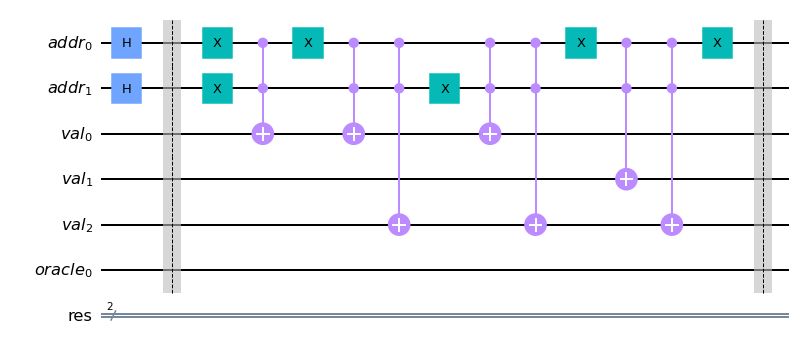

In [14]:
qram = QRam(2, 3, 1)
values = [1, 5, 6, 5]

qram.circ.h(qram.addr_reg[0])
qram.circ.h(qram.addr_reg[1])
qram.circ.barrier()

build_qram(qram, values)

qram.draw()

In [15]:
state = get_statevector_dict(run_on_statevector(qram.circ))

for k in state.keys():
    print(parse_state_string(qram, k))

addr:	0	value:	1
addr:	1	value:	5
addr:	3	value:	5
addr:	2	value:	6


Note: qram built like this is easy to uncompute. One may verify that QRAM is it's own Hermitian conjugate.

### Oracle
The next part we need in our solution is building an oracle which would "accept" the values we are looking for (for the phase kickback). The task specifies that we look for the values _"where two adjacent bits will always have different values"_. In other words, two adjacent bits have to have their XOR equal to 1. We use the fact that XOR may be implemented with 2 CNOT gates.

The oracle will consist of M qbits. The first M-1 will be a temporary results for each adjacent pair from value and the M-th qbit will be the output of the oracle, i.e. it will be euqal to 1 if and only if the value satisfies the condition.

We implement the oracle in the way it uncomputes itself.

In [16]:
def build_oracle(qram):
    for i in range(qram.M-1):
        qram.circ.cx(qram.val_reg[i], qram.oracle_reg[i])
        qram.circ.cx(qram.val_reg[i+1], qram.oracle_reg[i])
        
    qram.circ.mcx(qram.oracle_reg[:qram.M-1], qram.oracle_reg[-1])
    
    for i in range(qram.M-1):
        qram.circ.cx(qram.val_reg[i], qram.oracle_reg[i])
        qram.circ.cx(qram.val_reg[i+1], qram.oracle_reg[i])

### Diffuser
We implement the diffuser as described in the literature. This part of the algorithm does not require to be adjusted to the solution. Note, that we build it on the address register.

In [17]:
def build_diffuser(qram):
    for i in range(qram.N):
        qram.circ.h(qram.addr_reg[i])

    for i in range(qram.N):
        qram.circ.x(qram.addr_reg[i])

    qram.circ.h(qram.addr_reg[qram.N-1])
    qram.circ.mcx(qram.addr_reg[:qram.N-1], qram.addr_reg[qram.N-1])
    qram.circ.h(qram.addr_reg[qram.N-1])
    
    for i in range(qram.N):
        qram.circ.x(qram.addr_reg[i])
        
    for i in range(qram.N):
        qram.circ.h(qram.addr_reg[i])
    qram.circ.barrier()

### Circuit Initialization
We initialize the address register as the superposition of all addresses and the Oracle output as `|->`.

In [18]:
# initializes circuit for the Grover algorithm
def initialize_circ(qram):
    for i in range(qram.N):
        qram.circ.h(qram.addr_reg[i])

    output_qbit = qram.oracle_reg[-1]
    qram.circ.initialize([1, -1]/np.sqrt(2), output_qbit)
    qram.circ.barrier()

### Grover's Iteration
Now we have all components to compose a single iteration of the algorithm.

In [19]:
# builts single Grover's iteration on qram circuit
def add_iteration(qram, values):
    build_qram(qram, values)
    build_oracle(qram)
    # uncompute the qram
    build_qram(qram, values)
    build_diffuser(qram)
    return qram

# returns the number of iterations to get a near-optimal measurement for search space of size N
def goal_iterations(N):
    return int(np.floor(np.pi/4*np.sqrt(N)))

In [20]:
goal_iterations(32)

4

### Solution
Here we wrap all introduced components and make a method running Grover's search on Aer simulator.

In [21]:
def solution(qram, values):
    initialize_circ(qram)

    for i in range(goal_iterations(2**qram.N)):
        add_iteration(qram, values)
    
    measure(qram)
    res = run_on_aer(qram.circ)
    return res

Let's test the solution on the instance of the problem where we expect it to find only one index.
Let `N=5` (so there are 32 values), let `M=3` and let the values be list of 1's (`'001'`), 7's (`'111'`) and one instance of 2 (`'010'`) under index of 3 (`'00011'`).

/Users/koozco/qosf2021/qosf-4-tasks/qosf/lib/python3.8/site-packages/qiskit/utils/deprecation.py:62: DeprecationWarning: Using a qobj for run() is deprecated as of qiskit-aer 0.9.0 and will be removed no sooner than 3 months from that release date. Transpiled circuits should now be passed directly using `backend.run(circuits, **run_options).
  return func(*args, **kwargs)


{'00010': 1024}


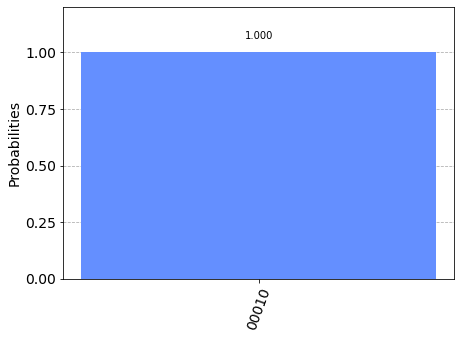

In [22]:
N = 5
M = 3
K = M
qram = QRam(N, M, K)
values = [1, 7, 2, 1] + [1, 7] * 14 # 32 elems

res = solution(qram, values)

print(res.get_counts())
plot_aer_counts(res)

That's pretty good result, right? Should we end here? No.
Please recall that Grover's Algorithm have caveats, begining with the fact that if we search for `N/2` out of `N`values the results are getting preety bad. Now we modify the previous example in the way that we will look for 2 values, 2 (`'010'`) and 5 (`'101'`).

{'01100': 14, '11111': 12, '11011': 10, '01111': 13, '10001': 11, '01001': 16, '00111': 9, '10100': 11, '10101': 9, '00101': 16, '11000': 17, '10000': 8, '11001': 13, '01010': 17, '11100': 18, '00100': 17, '00001': 13, '11010': 11, '01011': 15, '10111': 10, '01101': 12, '10011': 9, '01110': 14, '01000': 19, '11101': 17, '00110': 20, '10110': 12, '10010': 15, '11110': 307, '00011': 11, '00000': 19, '00010': 309}


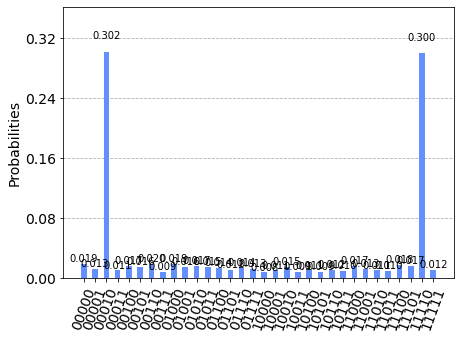

In [23]:
N = 5
M = 3
K = M
qram = QRam(N, M, K)
values = [1, 7, 2, 1] + [1, 7] * 13 + [5, 1] # 32 elems

res = solution(qram, values)

print(res.get_counts())
plot_aer_counts(res)

The results are still satisfying, however the noise started to appear. 

### Conclusions

I draw this conclusions based on all work I have done while working on the task and the experiments which may be found at the end of the notebook.

I think that the QRAM may be treated as an additional part of the Oracle - it is a mapping from the addresses to the values on which we construct oracle, the mapping from values to 0/1. I found the problem formulated this way easier to implement.

Don't be misled by good results at the begining. It is important to understand the problem and it's conditions. Based on the example of this algorithm - it is only efficient if values we are looking for are "rare" in the pool of all values. I think it may be true for the task, for every bit numbers `M` there are exactly two bitstrings satisfying the condition, one starting with `1` (e.g. `10101`) and one starting with `0` (e.g. `01010`). However, if we introduce the repeating values the performance gets worse.

The main conclusion is that QRAM may be a good option if we search for values "rare" in the context of all possible values.

### Experiments
Below I run some "experiments" which may give me (& the reader) better understanding of the problem.

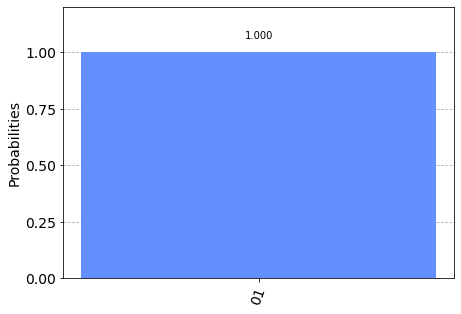

In [24]:
# space of 4 values, only one "correct"
N = 2
M = 3
K = M
qram = QRam(N, M, K)
values = [1, 2, 3, 1]

res = solution(qram, values)

plot_aer_counts(res)

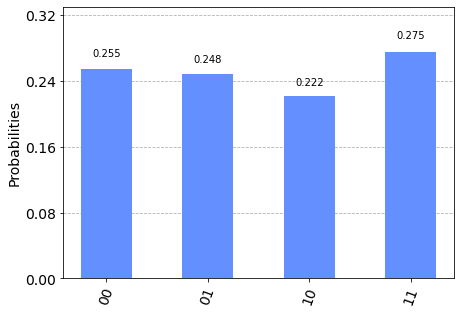

In [25]:
# space of 4 values, 2 are "correct"
N = 2
M = 3
K = M
qram = QRam(N, M, K)
values = [1, 2, 3, 5]

res = solution(qram, values)

plot_aer_counts(res)

In [26]:
# generates list of correct and incorrect values (in sense of the numbers) drawn from provided lists
def gen_values(correct, incorrect, correct_values, incorrect_values):
    values = list(np.random.choice(correct_values, correct)) + list(np.random.choice(incorrect_values, incorrect))
    np.random.shuffle(values)
    return values

In [27]:
print(gen_values(2, 4, [1, 2], [10, 20]))

[10, 2, 10, 10, 2, 10]


In [28]:
correct = [2, 5]
incorrect = [0, 1, 3, 4, 6, 7]

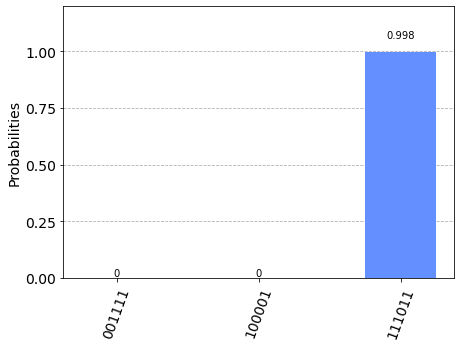

In [29]:
# space of 64 values, 1 is "correct"
N = 6
M = 3
K = M
qram = QRam(N, M, K)

correct_num = 1
values = gen_values(correct_num, 2**N - correct_num, correct, incorrect)

res = solution(qram, values)

plot_aer_counts(res)

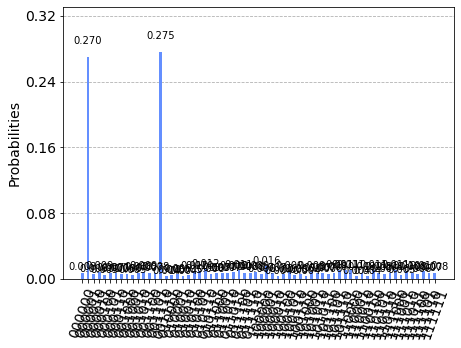

In [30]:
# space of 64 values, 2 are "correct"
N = 6
M = 3
K = M
qram = QRam(N, M, K)

correct_num = 2
values = gen_values(correct_num, 2**N - correct_num, correct, incorrect)

res = solution(qram, values)

plot_aer_counts(res)

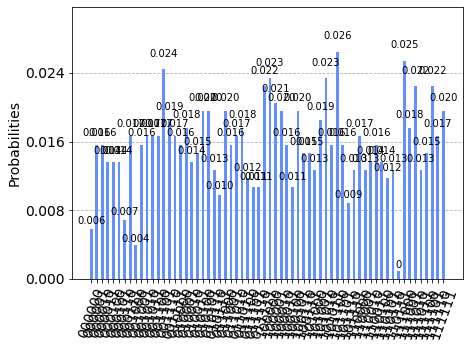

In [31]:
# space of 64 values, 4 are "correct"
N = 6
M = 3
K = M
qram = QRam(N, M, K)

correct_num = 4
values = gen_values(correct_num, 2**N - correct_num, correct, incorrect)

res = solution(qram, values)

plot_aer_counts(res)

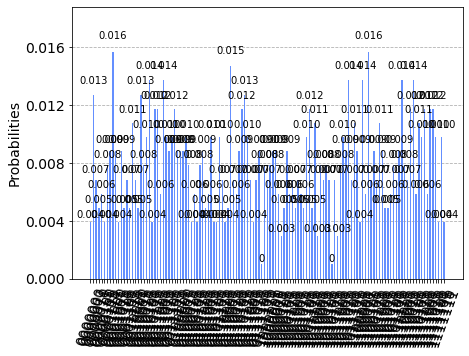

In [32]:
# space of 128 values, 4 are "correct"
N = 7
M = 3
K = M
qram = QRam(N, M, K)

correct_num = 4
values = gen_values(correct_num, 2**N - correct_num, correct, incorrect)

res = solution(qram, values)

plot_aer_counts(res)

### References
[1] Qiskit textbook - https://qiskit.org/textbook/ch-algorithms/grover.html

[2] Grover's work - https://arxiv.org/abs/quant-ph/9605043